# Data Challenge

Yao Yao

## Introduction

Here at Royal Caribbean Cruises Ltd. we have a commitment to reducing our footprint to the environment. Improving energy efficiency is a critical element in our quest for sustainability. Royal Caribbean Cruises Ltd. takes pride in being a leader in the use of new technologies to build and design ships that are more energy efficient. In one of our testing labs we have installed high-efficiency appliances as well as LED lightbulbs. 

## Task

As part of our lab testing you have been tasked to analyze and create a prediction model for the amount of energy used by these rooms. You have been supplied with the data set and the description of the fields. This is an open challenge where we want to see your ability to formulate and solve a problem as well as your creativity. Below are some of the things we are looking for:

### Import Packages

In [1]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from datetime import datetime
import time
from sklearn.model_selection import KFold
import itertools
import datetime as dt
from ggplot import *

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## a. Exploratory data analysis (Set up a story behind the data set given). 
### i. Identify the problem and how to address it using machine learning (ie. regression algorithm). 

Based on the data set description, the target variable is the total consumption in watt-hours based on the day, time, month, temperature, and humidity in 9 different rooms as well as the outside. The outside pressure, visibility and wind speed are also given as features to determine target energy use. Therefore, we are using regression to solve for a continuous target variable, figure out which features contribute the most to total consumption in watt-hours, and perhaps how to lower total consumption based on the different variables. I elected to use decision tree and random forest regressors because they tend to work well with a relatively sparse dataset than that for linear or polynomial regression. As I will illustrate below, the stepwise branches, leafs, and nodes will have better accuracy.

### Table 1: Data Set Description

In [2]:
from IPython.display import HTML, display
import tabulate
table = [["date","time year-month-day hour:minute:second"],
["TotalConsmp (AC+TV+LED+Peripherals)","energy use in Wh (Target)"],
["R1","Temperature in Room 1 in Celsius"],
["H_1","Humidity Room 1 in %"],
["R2","Temperature in Room 2 in Celsius"],
["H_2","Humidity in Room 2 in %"],
["R3","Temperature in Room 3 in Celsius"],
["H_3","Humidity in Room 3 in %"],
["R4","Temperature Room 4 in Celsius"],
["H_4","Humidity in Room 4 in %"],
["R5","Temperature in Room 5 in Celsius"],
["H_5","Humidity in Room 5 in %"],
["R6","Temperature Room 6 in Celsius"],
["H_6","Humidity in Room 6 in %"],
["R7","Temperature in Room 7 in Celsius"],
["H_7","Humidity in Room 7 in %"],
["R8","Temperature in Room 8 in Celsius"],
["H_8","Humidity in Room 8 in %"],
["R9","Temperature in Room 9 in Celsius"],
["H_9","Humidity in Room 9 in %"],
["To","Temperature outside in Celsius"],
["Pressure outside","in mm Hg"],
["RH_out","Humidity outside in %"],
["Windspeed","in m/s"],
["Visibility","in km"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

### Import dataset

In [3]:
df=pd.read_csv("data.csv", engine = 'c')

In [4]:
print("Table 2: Summary of Values")
df.describe().T

Table 2: Summary of Values


count        mean         std         min         25%  \
TotalConsmp  19735.0  101.496833  104.380829   10.000000   50.000000   
R1           19735.0   21.686571    1.606066   16.790000   20.760000   
H_1          19735.0   40.259739    3.979299   27.023333   37.333333   
R2           19735.0   20.341219    2.192974   16.100000   18.790000   
H_2          19735.0   40.420420    4.069813   20.463333   37.900000   
R3           19735.0   22.267611    2.006111   17.200000   20.790000   
H_3          19735.0   39.242500    3.254576   28.766667   36.900000   
R4           19735.0   20.855335    2.042884   15.100000   19.530000   
H_4          19735.0   39.026904    4.341321   27.660000   35.530000   
R5           19735.0   19.592106    1.844623   15.330000   18.277500   
H_5          19735.0   50.949283    9.022034   29.815000   45.400000   
R6           19735.0    7.910939    6.090347   -6.065000    3.626667   
H_6          19735.0   54.609083   31.149806    1.000000   30.025000   
R7           19735.0   20.267106    2.109993   15.390000   18.700000   
H_7          19735.0   35.388200    5.114208   23.200000   31.500000   
R8           19735.0   22.029107    1.956162   16.306667   20.790000   
H_8          19735.0   42.936165    5.224361   29.600000   39.066667   
R9           19735.0   19.485828    2.014712   14.890000   18.000000   
H_9          19735.0   41.552401    4.151497   29.166667   38.500000   
TempOutSide  19735.0    7.412580    5.318464   -5.000000    3.670000   
Press_mm_hg  19735.0  755.522602    7.399441  729.300000  750.933333   
H_OutSide    19735.0   79.750418   14.901088   24.000000   70.333333   
Windspeed    19735.0    4.039752    2.451221    0.000000    2.000000   
Visibility   19735.0   38.330834   11.794719    1.000000   29.000000   

                    50%         75%          max  
TotalConsmp   60.000000  100.000000  1110.000000  
R1            21.600000   22.600000    26.260000  
H_1           39.656667   43.066667    63.360000  
R2            20.000000   21.500000    29.856667  
H_2           40.500000   43.260000    56.026667  
R3            22.100000   23.290000    29.236000  
H_3           38.530000   41.760000    50.163333  
R4            20.666667   22.100000    26.200000  
H_4           38.400000   42.156667    51.090000  
R5            19.390000   20.619643    25.795000  
H_5           49.090000   53.663333    96.321667  
R6             7.300000   11.256000    28.290000  
H_6           55.290000   83.226667    99.900000  
R7            20.033333   21.600000    26.000000  
H_7           34.863333   39.000000    51.400000  
R8            22.100000   23.390000    27.230000  
H_8           42.375000   46.536000    58.780000  
R9            19.390000   20.600000    24.500000  
H_9           40.900000   44.338095    53.326667  
TempOutSide    6.920000   10.400000    26.100000  
Press_mm_hg  756.100000  760.933333   772.300000  
H_OutSide     83.666667   91.666667   100.000000  
Windspeed      3.666667    5.500000    14.000000  
Visibility    40.000000   40.000000    66.000000

### ii. Stats on energy consumption at different times (Monthly, Weekly, Day vs Night, Weekends vs Weekdays) (Idea example)

Days vs night, monthly, weekly dummy variables were made but ultiamtely not used because the decision tree process would have a better stepwise cutoff and threshold rate for determining how features could predict the target total consumption.

### iii. Effect of temp in energy consumption. (Idea example)

Which features that contribute most to energy consumption are later illustrated by feature importance associated for the best decision tree model.

## b. Pre-Processing (Data Cleanup, Feature Extraction, Feature Engineering).
### i. Please be as descriptive as possible.
### Data Cleanup

First, look for any missing variables and use monte carlo imputation to fill N/As. Luckily, the dataset is complete. Because we are using decision trees and random forest, those algorithms are more leninent for outliers because the threshold system would rule that to be one grouping instead of having extreme outliers influence the overall model for regular linear or polynomial modeling. In some cases, outliers are preferred because nuances with the dataset could be detected with decision trees and random forest that continuous equation models would not pick up on for the fitting process.

In [5]:
df.isnull().T.any().T.sum()

0

### Feature Extraction

Then, split the date into date and time columns

In [6]:
df['date'], df['time'] = df['date'].str.split(' ', 1).str

Convert the time into continuous hours from 0 to 24

In [7]:
df['time']= df['time'].str.split(':').apply(lambda x: int(x[0]) + int(x[1])/60)

Since the days start at the beginning of 2016, use that as a reference day for the subsequent days to follow for days since 1/1/2016.

In [8]:
def compare_dates(date):
    date_format = '%m/%d/%Y'
    current_date = datetime.strptime(date, date_format)  
    start = datetime(2016,1,1)
    diff = current_date - start
    return diff.days

#apply this function to your pandas dataframe
df['Days_Since_1_2016'] = df['date'].apply(compare_dates)

To create the weekday variable, convert into datetime and the numerical 1 to 7 constitute the days.

In [9]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [10]:
df['weekday'] = df['date'].dt.dayofweek + 1

Similarly for months, convert the months into numerical from 1 to 12

In [11]:
df['month']=df['date'].dt.month
df = df.drop(columns='date')

For weekends, create a dummy variable to find weekends

In [12]:
df['weekend'] = np.where(df['weekday'] > 5, 1, 0)

Summary of columns after new ones are created and separated

In [13]:
print("Table 3: Summary of Values")
df.describe().T

Table 3: Summary of Values


count        mean         std         min         25%  \
TotalConsmp        19735.0  101.496833  104.380829   10.000000   50.000000   
R1                 19735.0   21.686571    1.606066   16.790000   20.760000   
H_1                19735.0   40.259739    3.979299   27.023333   37.333333   
R2                 19735.0   20.341219    2.192974   16.100000   18.790000   
H_2                19735.0   40.420420    4.069813   20.463333   37.900000   
R3                 19735.0   22.267611    2.006111   17.200000   20.790000   
H_3                19735.0   39.242500    3.254576   28.766667   36.900000   
R4                 19735.0   20.855335    2.042884   15.100000   19.530000   
H_4                19735.0   39.026904    4.341321   27.660000   35.530000   
R5                 19735.0   19.592106    1.844623   15.330000   18.277500   
H_5                19735.0   50.949283    9.022034   29.815000   45.400000   
R6                 19735.0    7.910939    6.090347   -6.065000    3.626667   
H_6                19735.0   54.609083   31.149806    1.000000   30.025000   
R7                 19735.0   20.267106    2.109993   15.390000   18.700000   
H_7                19735.0   35.388200    5.114208   23.200000   31.500000   
R8                 19735.0   22.029107    1.956162   16.306667   20.790000   
H_8                19735.0   42.936165    5.224361   29.600000   39.066667   
R9                 19735.0   19.485828    2.014712   14.890000   18.000000   
H_9                19735.0   41.552401    4.151497   29.166667   38.500000   
TempOutSide        19735.0    7.412580    5.318464   -5.000000    3.670000   
Press_mm_hg        19735.0  755.522602    7.399441  729.300000  750.933333   
H_OutSide          19735.0   79.750418   14.901088   24.000000   70.333333   
Windspeed          19735.0    4.039752    2.451221    0.000000    2.000000   
Visibility         19735.0   38.330834   11.794719    1.000000   29.000000   
time               19735.0   11.918647    6.927784    0.000000    6.000000   
Days_Since_1_2016  19735.0   78.732556   39.564943   10.000000   44.000000   
weekday            19735.0    3.977249    1.985617    1.000000    2.000000   
month              19735.0    3.101647    1.339200    1.000000    2.000000   
weekend            19735.0    0.277274    0.447664    0.000000    0.000000   

                          50%         75%          max  
TotalConsmp         60.000000  100.000000  1110.000000  
R1                  21.600000   22.600000    26.260000  
H_1                 39.656667   43.066667    63.360000  
R2                  20.000000   21.500000    29.856667  
H_2                 40.500000   43.260000    56.026667  
R3                  22.100000   23.290000    29.236000  
H_3                 38.530000   41.760000    50.163333  
R4                  20.666667   22.100000    26.200000  
H_4                 38.400000   42.156667    51.090000  
R5                  19.390000   20.619643    25.795000  
H_5                 49.090000   53.663333    96.321667  
R6                   7.300000   11.256000    28.290000  
H_6                 55.290000   83.226667    99.900000  
R7                  20.033333   21.600000    26.000000  
H_7                 34.863333   39.000000    51.400000  
R8                  22.100000   23.390000    27.230000  
H_8                 42.375000   46.536000    58.780000  
R9                  19.390000   20.600000    24.500000  
H_9                 40.900000   44.338095    53.326667  
TempOutSide          6.920000   10.400000    26.100000  
Press_mm_hg        756.100000  760.933333   772.300000  
H_OutSide           83.666667   91.666667   100.000000  
Windspeed            3.666667    5.500000    14.000000  
Visibility          40.000000   40.000000    66.000000  
time                12.000000   17.833333    23.833333  
Days_Since_1_2016   79.000000  113.000000   147.000000  
weekday              4.000000    6.000000     7.000000  
month                3.000000    4.000000     5.000000  
weekend              0.0000

Total consumption has a right skew and is corrected by logging the values

In [14]:
log_columns = ['TotalConsmp']

for column in log_columns:
    df[column+'*'] = np.log(df[column]+1)

df = df.drop(columns=log_columns)

### Feature Engineering

The heat index combines humidity and temperature into one overall temperature: https://en.wikipedia.org/wiki/Heat_index#Formula. Allowing for the assumption that humans are in the rooms, the "feeling" of temperature can be greatly influenced by how humid a room is. Therefore, a equation is used to determine if overall temperature could influence heating, which would contribute to overall energy consumption. Because the heat index is in Fahrenheit, the temperature has to be converted and then converted back into the metric system because the units of all the rest of the dataset is in the metric system.

In [15]:
40*1.8+32

104.0

As an example, if the temperature is 85 degrees F and the room has a humidity of 70%, the overall heat index value is 92.7, which checks out using this online calculator for the heat index: https://www.calculator.net/heat-index-calculator.html

In [16]:
c_1 = -42.379
c_2 = 2.04901523
c_3 = 10.14333127
c_4 = -0.22475541
c_5 = -6.83783 * 10**-3
c_6 = -5.481717 * 10**-2
c_7 = 1.22874 * 10**-3
c_8 = 8.5282 * 10**-4
c_9 = -1.99 * 10**-6

T = 85
R = 70

HI = c_1 + c_2 * T + c_3 * R + c_4 * T * R + c_5 * T**2 + c_6 * R**2 + c_7 * T**2 * R + c_8 * T * R**2 + c_9 * T**2 * R**2
HI

92.70214919999992

Therefore, each temperature in celcius is converted to fahrenheit for the heat index, which is then converted back into celcius to maintain the same metric units for the whole dataset.

In [17]:
room_columns = ['R1','R2','R3','R4','R5','R6','R7','R8','R9']
humid_columns = ['H_1','H_2','H_3','H_4','H_5','H_6','H_7','H_8','H_9']

for T, R in zip(room_columns, humid_columns):
    df[T+R] = (c_1 + \
               c_2 * (df[T] * 1.8 + 32) + \
               c_3 * df[R] + \
               c_4 * (df[T] * 1.8 + 32) * df[R] + \
               c_5 * (df[T] * 1.8 + 32)**2 + \
               c_6 * df[R]**2 + \
               c_7 * (df[T] * 1.8 + 32)**2 * df[R] + \
               c_8 * (df[T] * 1.8 + 32) * df[R]**2 + \
               c_9 * (df[T] * 1.8 + 32)**2 * df[R]**2 - 32) / 1.8

On the same website, wind chill has to be factored in as well for the outside that the inside does not include to calculate overall temperature: https://www.calculator.net/wind-chill-calculator.html. Using the Australian Apparent temperature equation, it factors everything in the metric system involving temperature, humidity, and wind speed to create one overall heat and wind chill index: https://en.wikipedia.org/wiki/Wind_chill#Australian_Apparent_Temperature.

In [18]:
outTemp = ['TempOutSide']
outHumid = ['H_OutSide']
outWind = ['Windspeed']

for T, H, W in zip(outTemp, outHumid, outWind):
    df[T+H] = df[T] + 0.33*(df[H]/100*6.105*np.exp((17.27*df[T])/(237.7+df[T]))) - 0.7*df[W] - 4

Now that the engineered features are created, we graph for skewity for which features need to be adjusted by the log scale. Since the procedure is recursive, we found that total consumption need to be transformed by log.

In [19]:
df.head().T

0           1           2           3  \
R1                     19.890000   19.890000   19.890000   19.890000   
H_1                    47.596667   46.693333   46.300000   46.066667   
R2                     19.200000   19.200000   19.200000   19.200000   
H_2                    44.790000   44.722500   44.626667   44.590000   
R3                     19.790000   19.790000   19.790000   19.790000   
H_3                    44.730000   44.790000   44.933333   45.000000   
R4                     19.000000   19.000000   18.926667   18.890000   
H_4                    45.566667   45.992500   45.890000   45.723333   
R5                     17.166667   17.166667   17.166667   17.166667   
H_5                    55.200000   55.200000   55.090000   55.090000   
R6                      7.026667    6.833333    6.560000    6.433333   
H_6                    84.256667   84.063333   83.156667   83.423333   
R7                     17.200000   17.200000   17.200000   17.133333   
H_7                    41.626667   41.560000   41.433333   41.290000   
R8                     18.200000   18.200000   18.200000   18.100000   
H_8                    48.900000   48.863333   48.730000   48.590000   
R9                     17.033333   17.066667   17.000000   17.000000   
H_9                    45.530000   45.560000   45.500000   45.400000   
TempOutSide             6.600000    6.480000    6.370000    6.250000   
Press_mm_hg           733.500000  733.600000  733.700000  733.800000   
H_OutSide              92.000000   92.000000   92.000000   92.000000   
Windspeed               7.000000    6.666667    6.333333    6.000000   
Visibility             63.000000   59.166667   55.333333   51.500000   
time                   17.000000   17.166667   17.333333   17.500000   
Days_Since_1_2016      10.000000   10.000000   10.000000   10.000000   
weekday                 1.000000    1.000000    1.000000    1.000000   
month                   1.000000    1.000000    1.000000    1.000000   
weekend                 0.000000    0.000000    0.000000    0.000000   
TotalConsmp*            4.510860    4.510860    4.394449    4.510860   
R1H_1                  25.291766   25.304843   25.308797   25.310644   
R2H_2                  25.567674   25.567213   25.566499   25.566207   
R3H_3                  25.346069   25.346214   25.346459   25.346524   
R4H_4                  25.659433   25.659675   25.694185   25.711522   
R5H_5                  26.540775   26.540775   26.548737   26.548737   
R6H_6                  39.992728   40.767003   42.194263   42.520584   
R7H_7                  26.581827   26.577615   26.569489   26.605550   
R8H_8                  26.064899   26.065599   26.068044   26.133269   
R9H_9                  26.878495   26.853384   26.903746   26.900975   
TempOutSideH_OutSide    0.655387    0.744415    0.845624    0.934990   

                               4  
R1                     19.890000  
H_1                    46.333333  
R2                     19.200000  
H_2                    44.530000  
R3                     19.790000  
H_3                    45.000000  
R4                     18.890000  
H_4                    45.530000  
R5                     17.200000  
H_5                    55.090000  
R6                      6.366667  
H_6                    84.893333  
R7                     17.200000  
H_7                    41.230000  
R8                     18.100000  
H_8                    48.590000  
R9                     17.000000  
H_9                    45.400000  
TempOutSide             6.130000  
Press_mm_hg           733.900000  
H_OutSide              92.000000  
Windspeed               5.666667  
Visibility             47.666667  
time                   17.666667  
Days_Since_1_2016      10.000000  
weekday                 1.000000  
month                   1.000000  
weekend                 0.000000  
TotalConsmp*            4.615121  
R1H_1                  25.308503  
R2H_2                  25.565707  
R3H_3                  25.3465

When graphing frequency of distributions for the features, most of them look normal and the decision tree and random forest procedure would sequester some piecewise factors and thresholds for better regression prediction

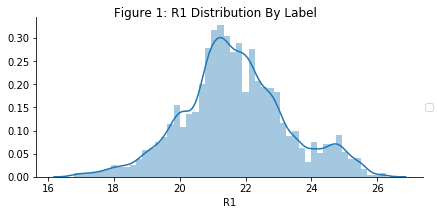

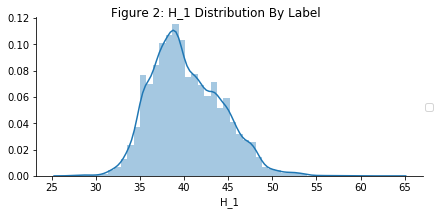

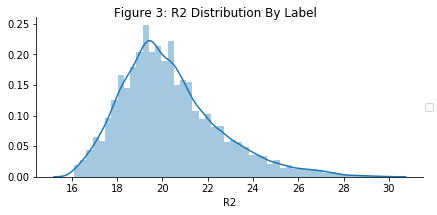

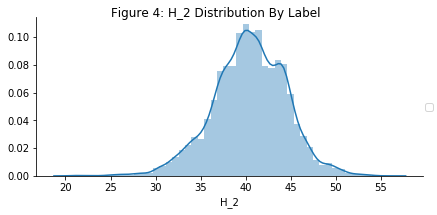

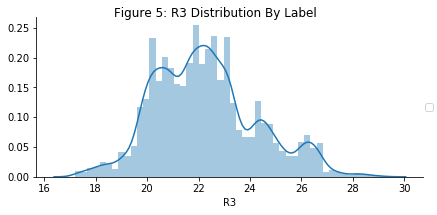

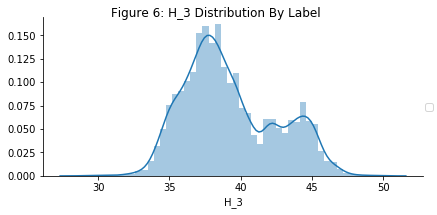

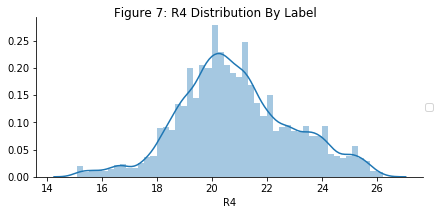

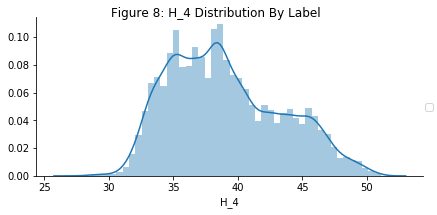

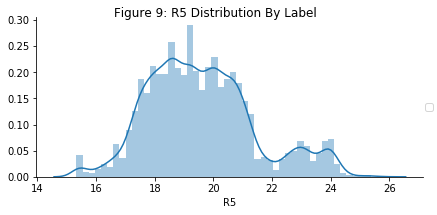

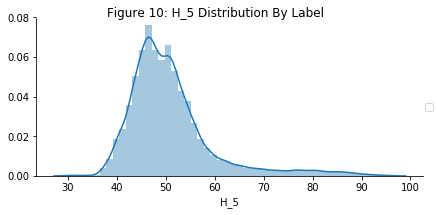

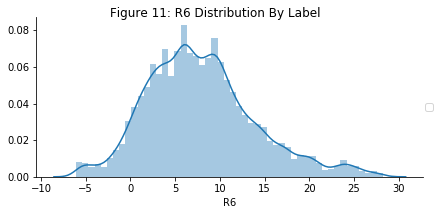

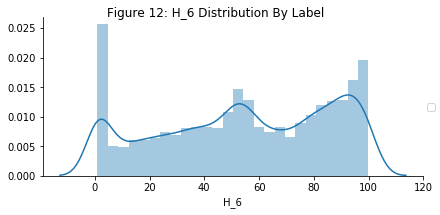

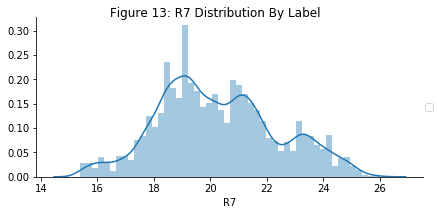

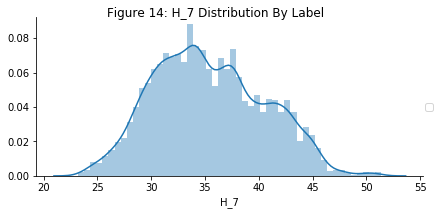

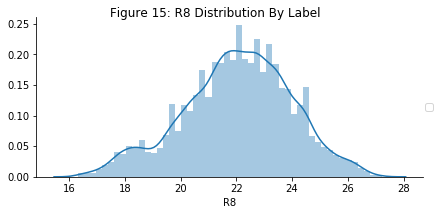

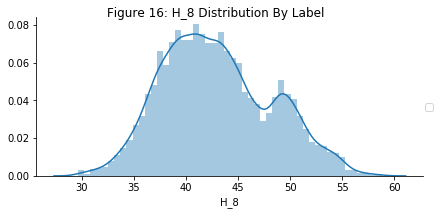

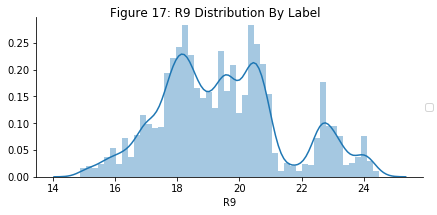

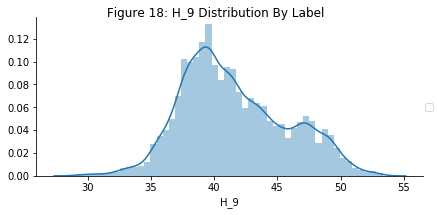

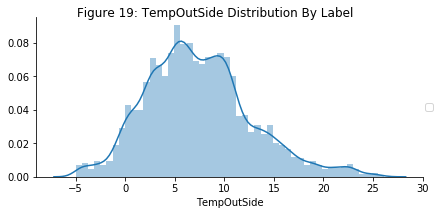

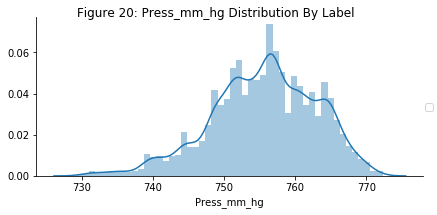

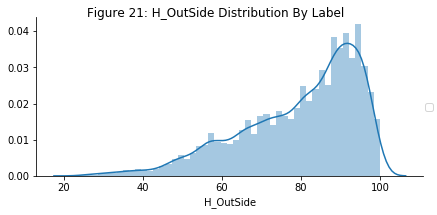

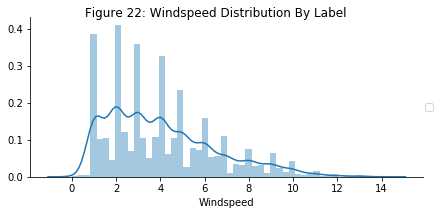

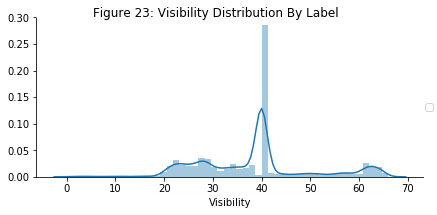

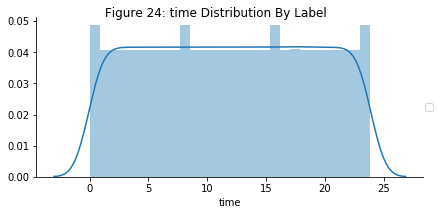

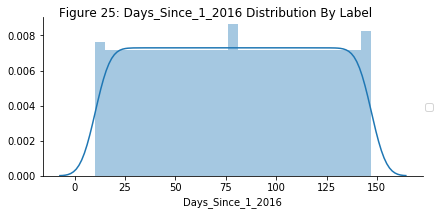

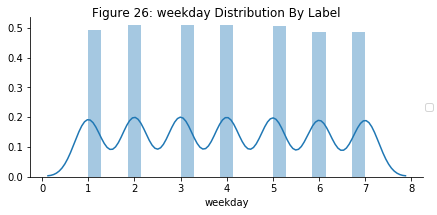

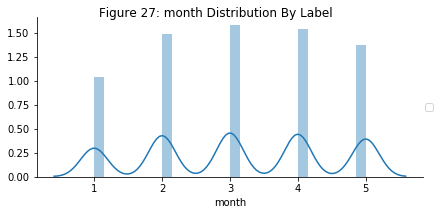

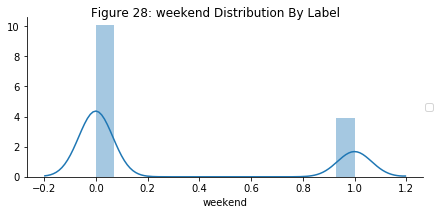

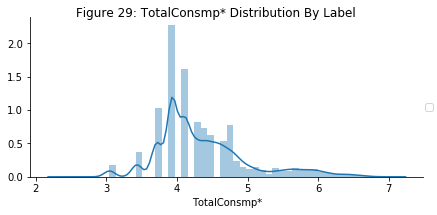

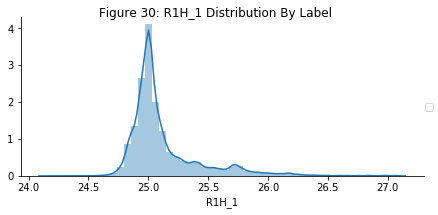

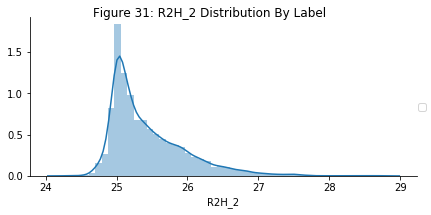

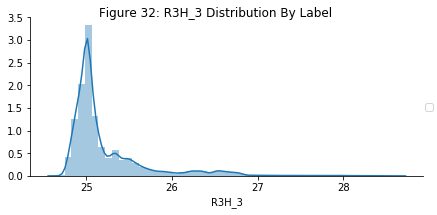

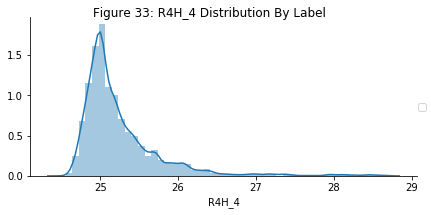

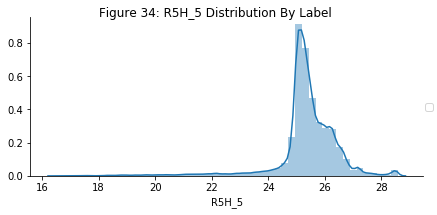

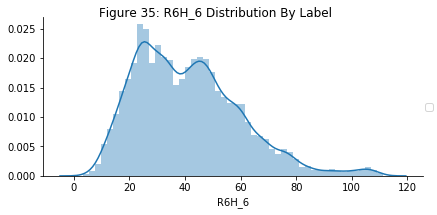

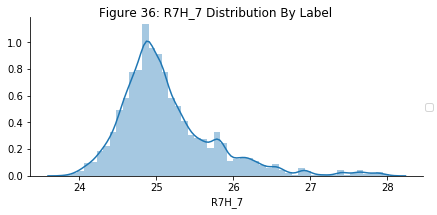

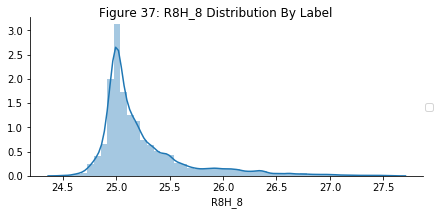

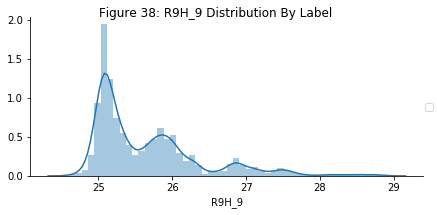

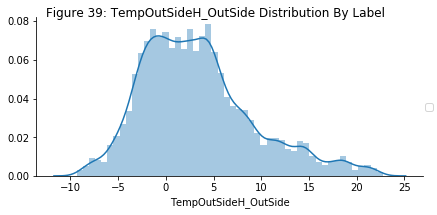

In [20]:
plt.rcParams['figure.max_open_warning']=40
colnames=list(df.select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(df,aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution By Label"]))))
    plt.show()

When graphing the difference between weekends and weekdays, it is determined that the separation of total consumption over time of day is randomized in pattern.

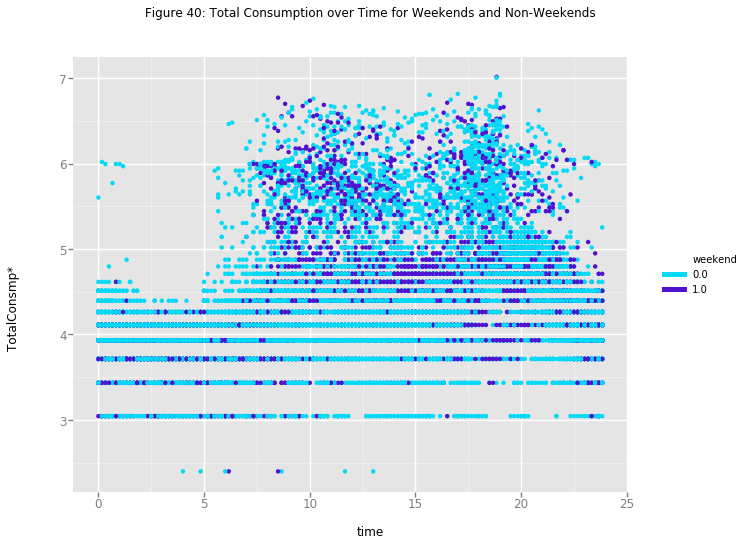

<ggplot: (-9223372036841358262)>

In [21]:
ggplot(df, aes(x='time', y='TotalConsmp*', color='weekend')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
    + ggtitle("Figure 40: Total Consumption over Time for Weekends and Non-Weekends")

When graphing the difference among months, it is determined that the separation of total consumption over months is mostly randomized in pattern, where January and cold months have higher total consumption of energy possibly due to heating

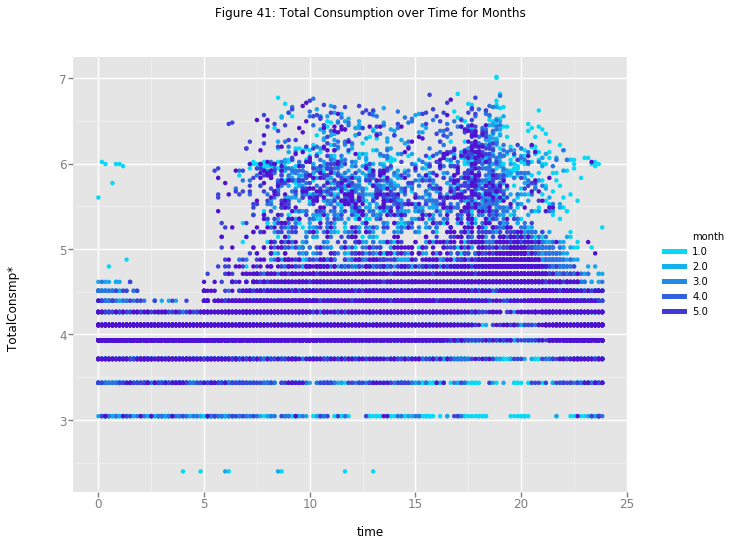

<ggplot: (-9223372036841358178)>

In [22]:
ggplot(df, aes(x='time', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 41: Total Consumption over Time for Months")

When graphing temperature outside and total consumption between weekends and weekdays, it is determined that there is a striped pattern that the random forest could recognize when fitting the model.

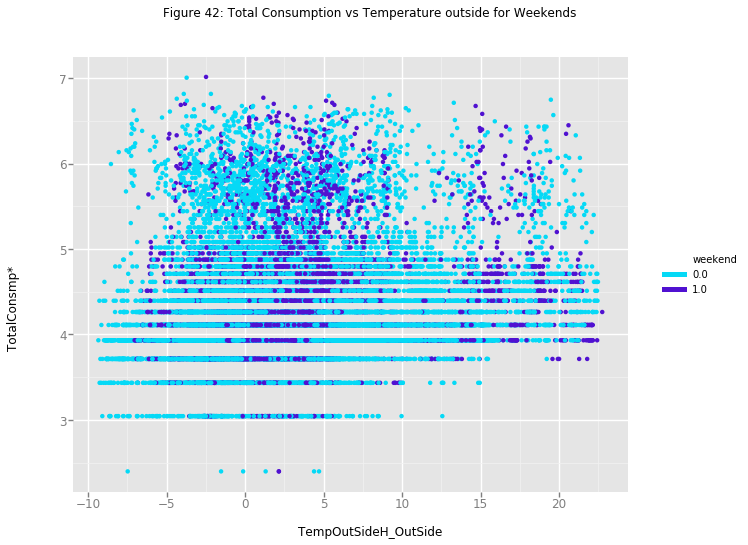

<ggplot: (13105486)>

In [23]:
ggplot(df, aes(x='TempOutSideH_OutSide', y='TotalConsmp*', color='weekend')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 42: Total Consumption vs Temperature outside for Weekends")

When graphing temperature outside and total consumption among months, the winter months were colder and could slightly influence total consumption.

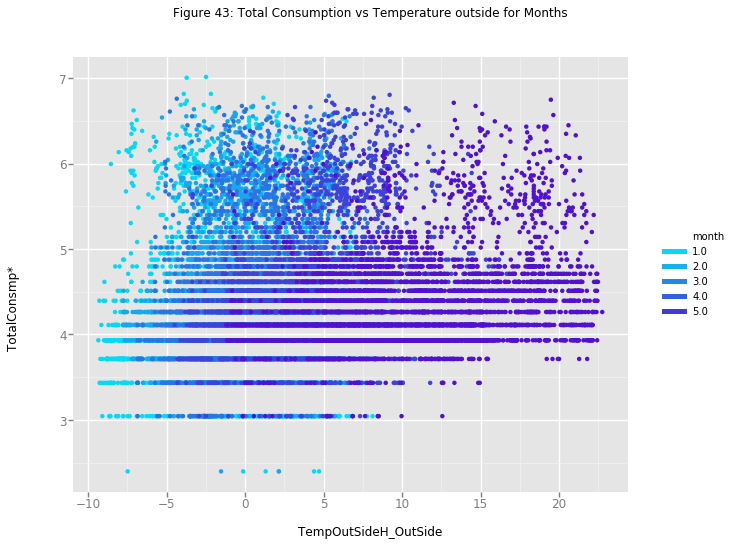

<ggplot: (-9223372036841703196)>

In [24]:
ggplot(df, aes(x='TempOutSideH_OutSide', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 43: Total Consumption vs Temperature outside for Months")

When graphing for various rooms for total consumption for different heat indexes, it is determined that some rooms are kept at a higher temperature depending on month and temperature outside than others. Again, these nuances in data pattern would be picked up by the decision tree/random forest algorithms.

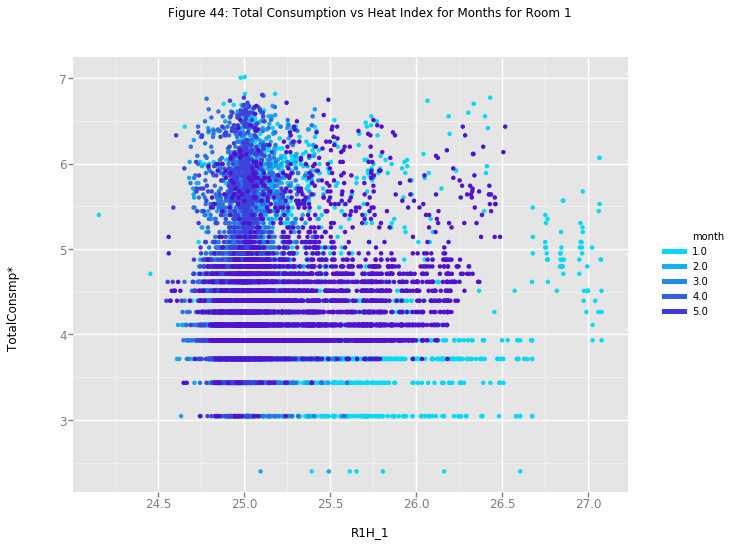

<ggplot: (14270689)>

In [25]:
ggplot(df, aes(x='R1H_1', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 44: Total Consumption vs Heat Index for Months for Room 1")

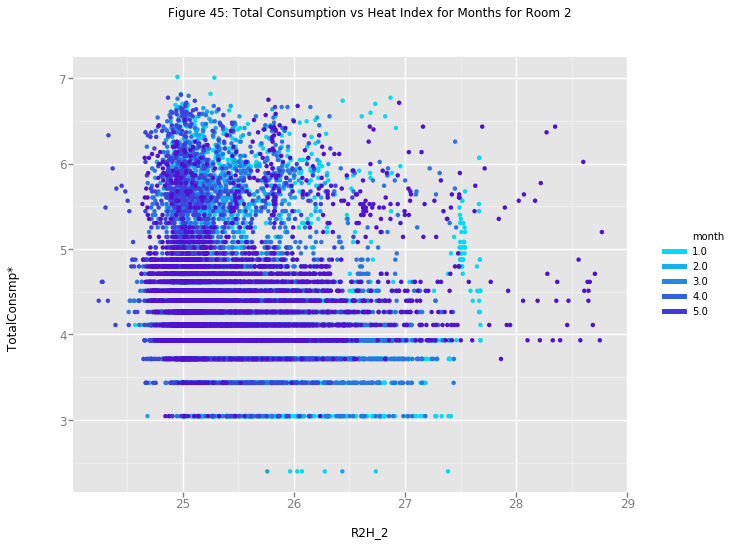

<ggplot: (-9223372036841803127)>

In [26]:
ggplot(df, aes(x='R2H_2', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 45: Total Consumption vs Heat Index for Months for Room 2")

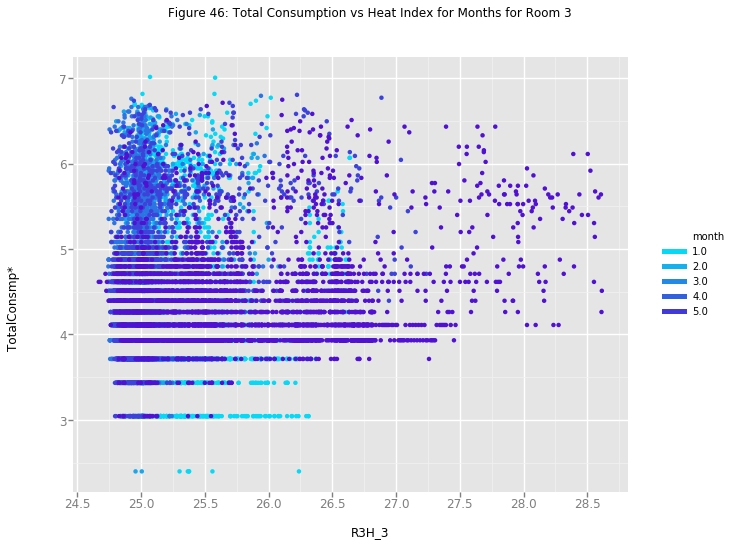

<ggplot: (-9223372036842052366)>

In [27]:
ggplot(df, aes(x='R3H_3', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 46: Total Consumption vs Heat Index for Months for Room 3")

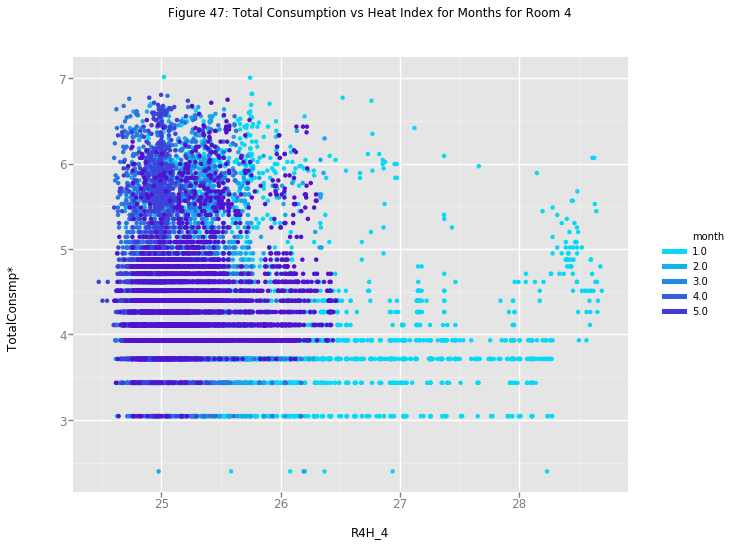

<ggplot: (14312438)>

In [28]:
ggplot(df, aes(x='R4H_4', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 47: Total Consumption vs Heat Index for Months for Room 4")

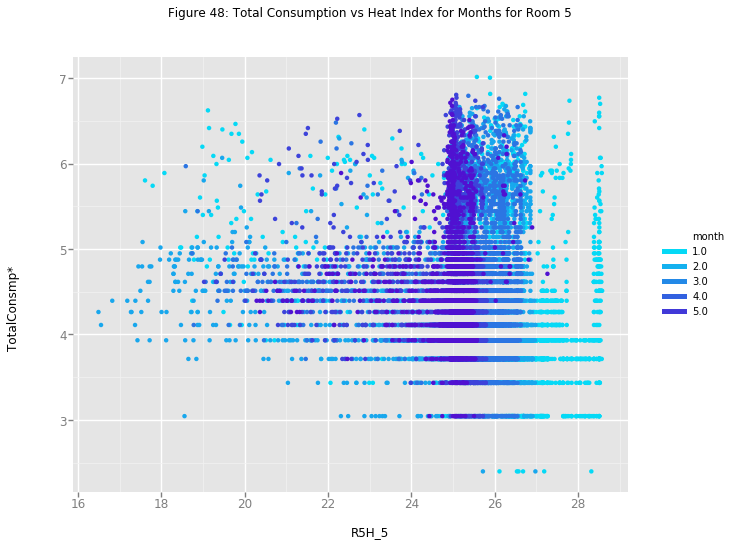

<ggplot: (13401327)>

In [29]:
ggplot(df, aes(x='R5H_5', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 48: Total Consumption vs Heat Index for Months for Room 5")

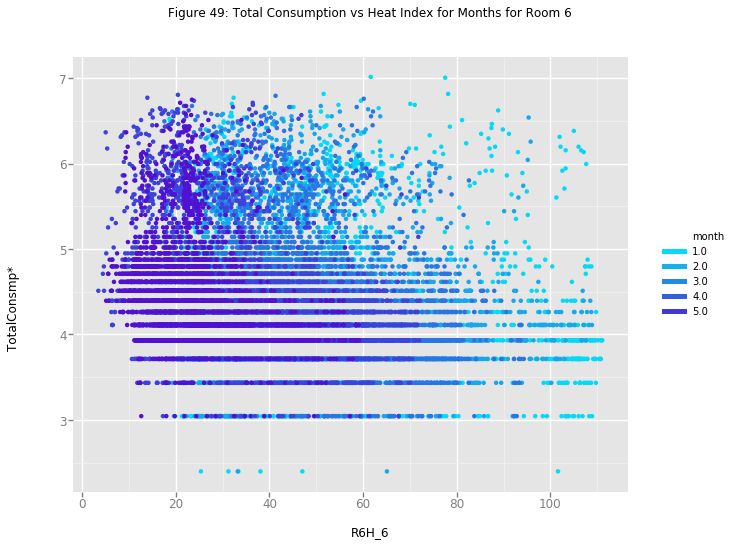

<ggplot: (-9223372036841566183)>

In [30]:
ggplot(df, aes(x='R6H_6', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 49: Total Consumption vs Heat Index for Months for Room 6")

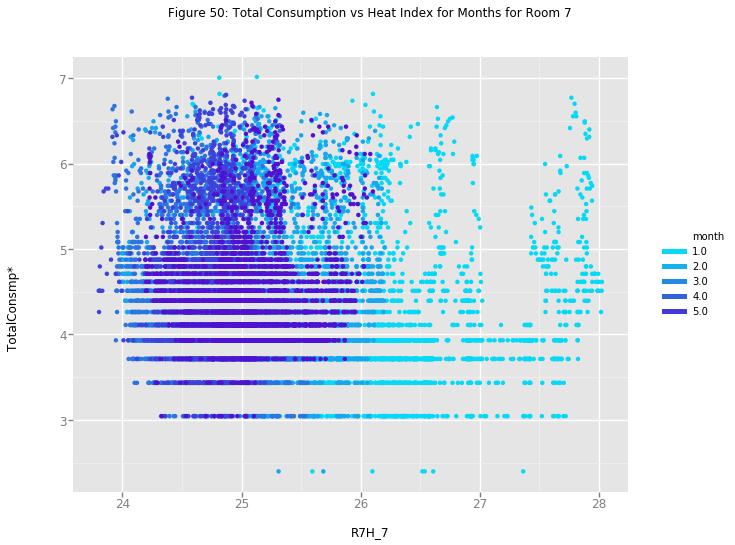

<ggplot: (12931802)>

In [31]:
ggplot(df, aes(x='R7H_7', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 50: Total Consumption vs Heat Index for Months for Room 7")

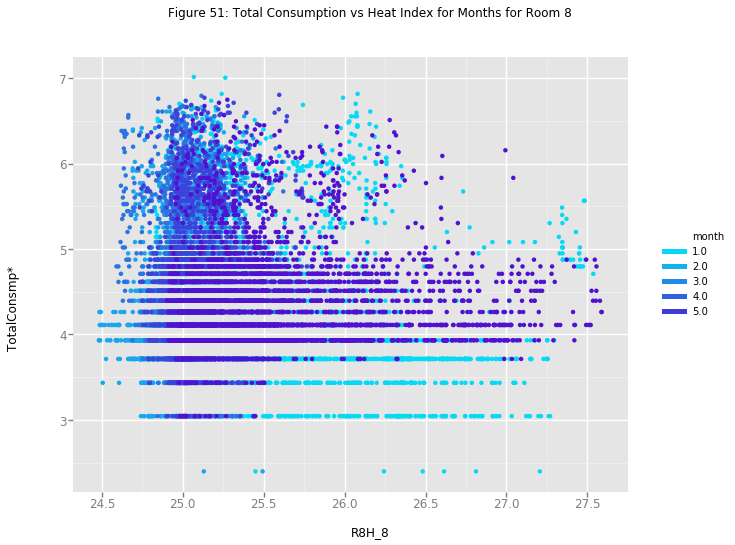

<ggplot: (13147407)>

In [32]:
ggplot(df, aes(x='R8H_8', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 51: Total Consumption vs Heat Index for Months for Room 8")

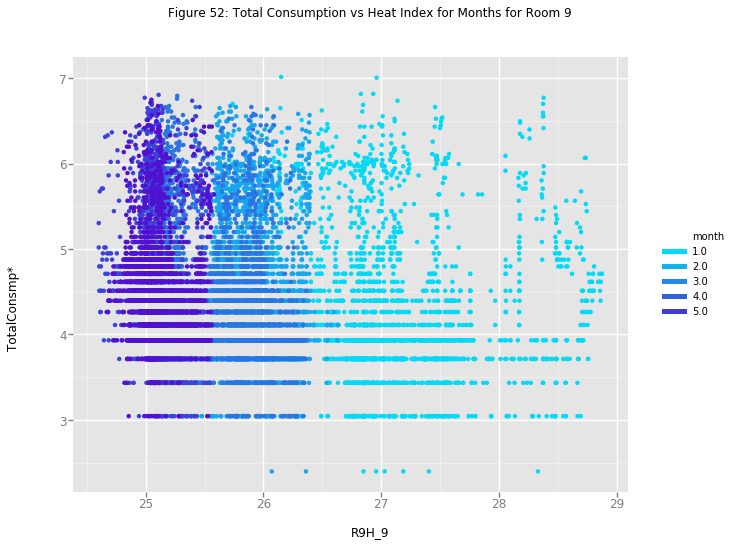

<ggplot: (13207279)>

In [33]:
ggplot(df, aes(x='R9H_9', y='TotalConsmp*', color='month')) + geom_point() + scale_color_gradient(low='#05D9F6', high='#5011D1') \
        + ggtitle("Figure 52: Total Consumption vs Heat Index for Months for Room 9")

## c. Modeling (Explain the reasoning behind the model).
### i. Explain your reasoning behind the Algorithm used.

As stated above, we are using decision trees and random forest, where those algorithms are more lenient for outliers because the threshold system would rule that to be one grouping instead of having extreme outliers influence the overall model for regular linear or polynomial modeling. In some cases, outliers are preferred because nuances with the dataset could be detected with decision trees and random forest that continuous equation models would not pick up on for the fitting process.

Due to the recursive nature of the process, dummy variables were made for months and days of the week but were then redacted because they had no influence on the overall model. The code is in tact just in case we would want to go back to explore

In [34]:
# colnames=["month", "weekday"]
# for i in colnames[0:]:
#     # Fill missing data with the word "Missing"
#     df[i].fillna("Missing", inplace=True)
#     # Create array of dummies
#     dummies = pd.get_dummies(df[i], prefix=i)
#     # Update X to include dummies and drop the main variable
#     df = pd.concat([df, dummies], axis=1)
#     df.drop([i], axis=1, inplace=True)

There are several ways to index the target and independent features

In [35]:
y = df.pop('TotalConsmp*')
# ids = pd.Series(y.unique())
# ids = ids.reset_index().set_index(0)
# y_int = ids.loc[y]

## d. Results (Look into how the results are presented).
### i. Please remember to remove a sample of your dataset for testing purposes

Instead of getting a 'lucky sample' by splitting an arbitrary amount by index, the kfold method was used to shuffle the indexed training and testing data values and have the model learn from every fold so it is not overfitted on one given 80:20 split. From the folding process, the training and testing datasets are split 3 times and shuffled to avoid overfitting of a single split dataset with the regular 80:20 split.

In [36]:
# x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=2)
kf = KFold(n_splits = 3, shuffle = True, random_state = 2)

In [37]:
# print('Training Features Shape:', x_train.shape)
# print('Training Target Shape:', y_train.shape)
# print('Testing Features Shape:', x_test.shape)
# print('Testing Target Shape:', y_test.shape)

### Decision tree regressor vs random forest regressor

Due to the recursive method of the modeling process, decision trees and random forest did the best for mean absolute error and accuracy. R^2 was not used as a method to evaulate performance because of how amorphous the data pattern is when graphed. Because the error is in decimals, mean absolute error was used over mean squared error.

In [38]:
model2 = DecisionTreeRegressor()

for train_idx, test_idx in kf.split(df, y):
    model2.fit(df.loc[train_idx],y.loc[train_idx])
    error = abs(model2.predict(df.loc[test_idx]) - y.loc[test_idx])
    print('Mean Absolute Error:', round(np.mean(error), 2), 'log wH.')
    print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

Mean Absolute Error: 0.28 log wH.
Accuracy: 93.61 %.
Mean Absolute Error: 0.29 log wH.
Accuracy: 93.51 %.
Mean Absolute Error: 0.28 log wH.
Accuracy: 93.62 %.


In [39]:
model3 = RandomForestRegressor(random_state=2)

for train_idx, test_idx in kf.split(df, y):
    model3.fit(df.loc[train_idx],y.loc[train_idx])
    error = abs(model3.predict(df.loc[test_idx]) - y.loc[test_idx])
    print('Mean Absolute Error:', round(np.mean(error), 2), 'log wH.')
    print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

Mean Absolute Error: 0.24 log wH.
Accuracy: 94.54 %.
Mean Absolute Error: 0.24 log wH.
Accuracy: 94.47 %.
Mean Absolute Error: 0.25 log wH.
Accuracy: 94.36 %.


With the baseline tests, the random forest regressor did slightly better for both metrics and will be further used to determine the best parameters for this algorithm.

In [40]:
model4 = RandomForestRegressor(n_estimators=100, random_state=2)

for train_idx, test_idx in kf.split(df, y):
    model4.fit(df.loc[train_idx],y.loc[train_idx])
    error = abs(model4.predict(df.loc[test_idx]) - y.loc[test_idx])
    print('Mean Absolute Error:', round(np.mean(error), 2), 'log wH.')
    print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

Mean Absolute Error: 0.23 log wH.
Accuracy: 94.82 %.
Mean Absolute Error: 0.23 log wH.
Accuracy: 94.76 %.
Mean Absolute Error: 0.24 log wH.
Accuracy: 94.71 %.


In [41]:
feature_list = list(df.columns)

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = model4.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

In [42]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph.write_png('tree.png')

The complexity of the random forest is shown below, and is more reliable than linear or polynomial regression

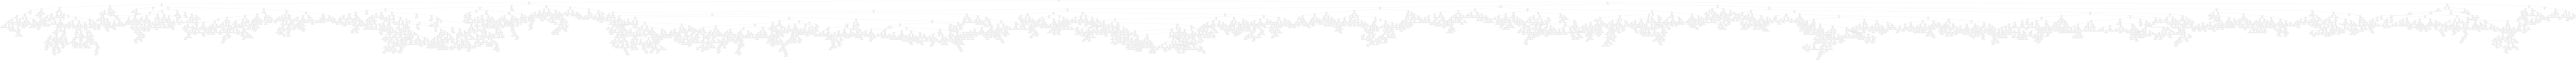

In [43]:
from IPython.display import Image
Image("tree.png")

In [44]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(df.loc[train_idx],y.loc[train_idx])
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

This embedded image generated by the model shows the mean squared error of how time and room and heat index are sequestered into their own regression values on the small scale

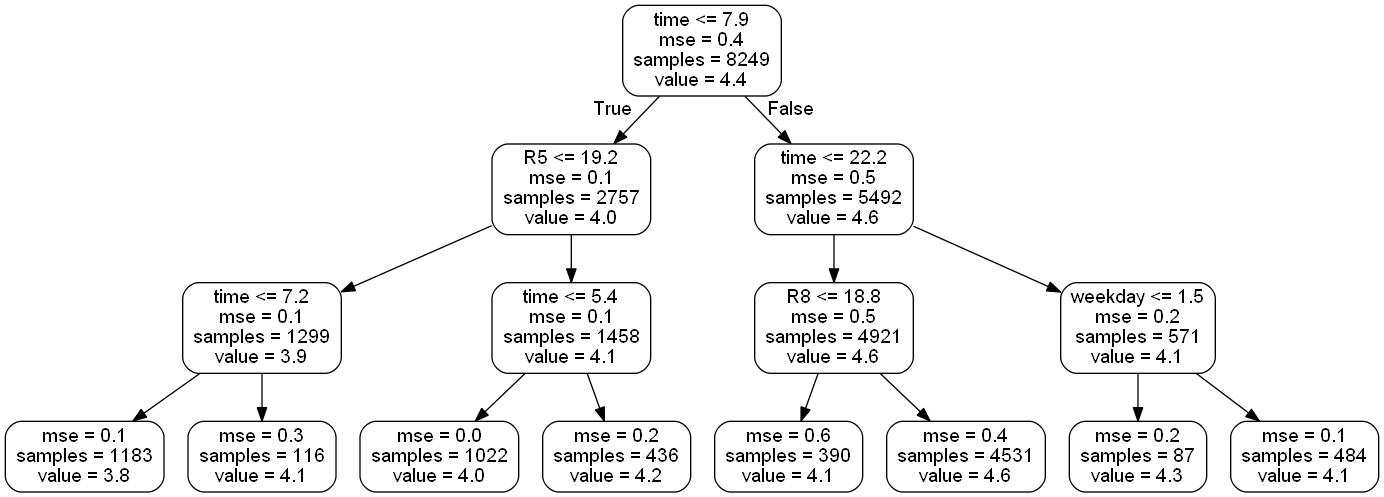

In [45]:
Image("small_tree.png")

### Feature Importance

Time of day, certain room temperature, heat index, and days since the beginning of 2016 proved to be the top important features to determine total energy consumption. Due to the complexity of the heat index and apparent temperature from feature engineering, those are included with their original temperature, humidity, and wind chill constituents because some rooms may be more used by people and others are more for appliances, however warm or however cold depending on the outside temperature. Even though pressure does not have an equation for feature engineering, it was surprising that it contributed towards the top 5 important features [Figure 53]. 

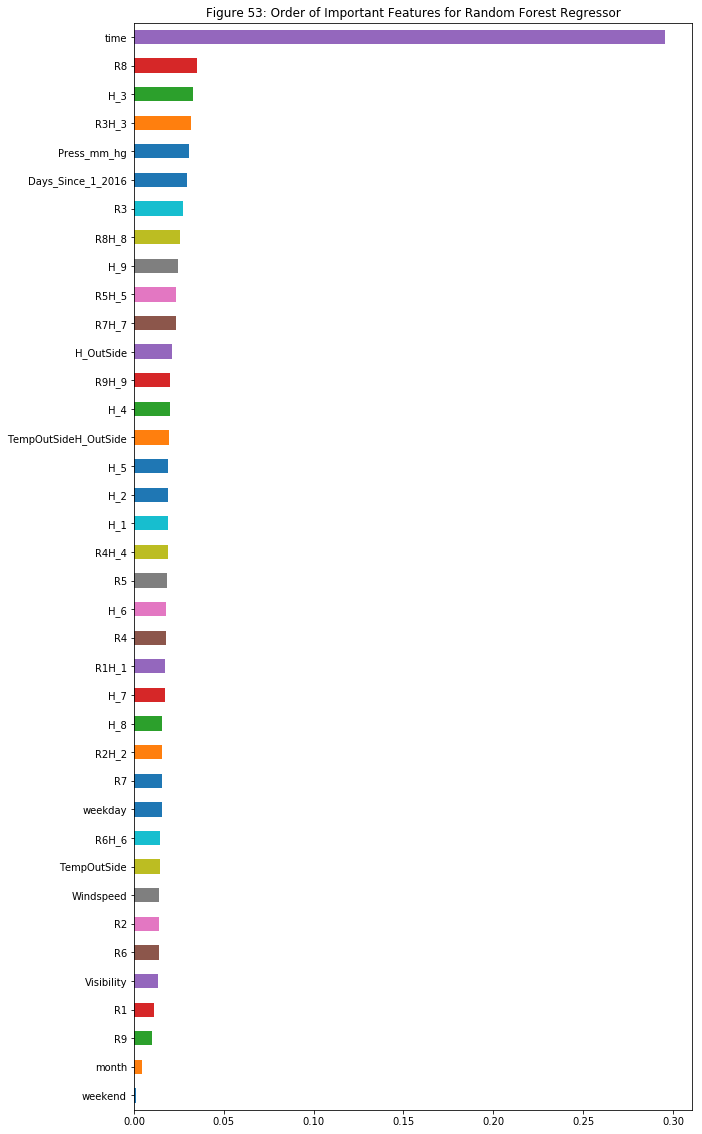

In [46]:
feature_importances = pd.Series(model4.feature_importances_, index=df.columns)
feature_importances.sort_values().plot(kind="barh", figsize=(10,20),
                                       title = "Figure 53: Order of Important Features for Random Forest Regressor");

In [47]:
feature_importances.sort_values(ascending=False)[:35]

time                    0.295723
R8                      0.035195
H_3                     0.033050
R3H_3                   0.031790
Press_mm_hg             0.030872
Days_Since_1_2016       0.029488
R3                      0.027095
R8H_8                   0.025489
H_9                     0.024250
R5H_5                   0.023327
R7H_7                   0.023307
H_OutSide               0.021171
R9H_9                   0.020262
H_4                     0.020009
TempOutSideH_OutSide    0.019353
H_5                     0.019191
H_2                     0.019139
H_1                     0.019046
R4H_4                   0.018962
R5                      0.018322
H_6                     0.018046
R4                      0.017866
R1H_1                   0.017394
H_7                     0.017383
H_8                     0.015880
R2H_2                   0.015827
R7                      0.015793
weekday                 0.015531
R6H_6                   0.014680
TempOutSide             0.014511
Windspeed 

In [48]:
feature_importances.sort_values(ascending=False)[-3:]

R9         0.009904
month      0.004236
weekend    0.001361
dtype: float64

The features that contribute the least for the winning model in random forest are room 9's temperature, weekend boolean, and what month it is. Room 9 for total energy output is more based on humidity factor. Weekend doesn't affect energy consumption as the whole spectrum of the week from 1 to 7. Month can be redundant to how many days since the start of 2016 as well as colinear to outside temperature.

In [49]:
# x_test.drop(feature_importances.sort_values(ascending=False)[-3:].index, axis=1, inplace=True)
# x_train.drop(feature_importances.sort_values(ascending=False)[-3:].index, axis=1, inplace=True)

df.drop(feature_importances.sort_values(ascending=False)[-3:].index, axis=1, inplace=True)

### Lesser features removal to compensate for less model overfitting

After dropping the less important features with 0.01 feature importance or lower, the mean absolute and accuracy values increased possibly because those features were overfitted and the algorithm became better once those were removed.

In [50]:
model = RandomForestRegressor(n_estimators=100, random_state=2)

for train_idx, test_idx in kf.split(df, y):
    model.fit(df.loc[train_idx],y.loc[train_idx])
    error = abs(model.predict(df.loc[test_idx]) - y.loc[test_idx])
    print('Mean Absolute Error:', round(np.mean(error), 2), 'log wH.')
    print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

Mean Absolute Error: 0.23 log wH.
Accuracy: 94.82 %.
Mean Absolute Error: 0.23 log wH.
Accuracy: 94.77 %.
Mean Absolute Error: 0.24 log wH.
Accuracy: 94.71 %.


Time of day is the most important factor for determining total energy consumption and the best way to visualize the prediction values after is to have time of day on the x axis while comparing total consumption on the y.

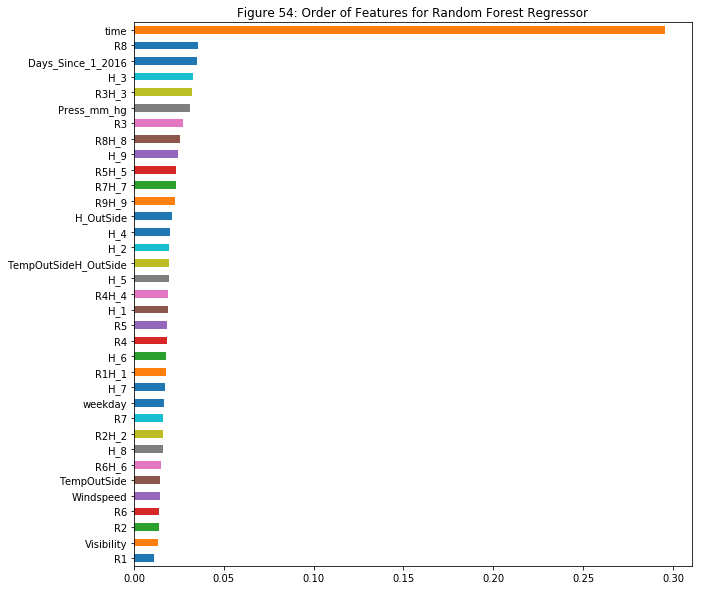

In [51]:
feature_importances = pd.Series(model.feature_importances_, index=df.columns)
feature_importances.sort_values().plot(kind="barh", figsize=(10,10),
                                       title = "Figure 54: Order of Features for Random Forest Regressor");

### Hyperparameter tuning

Had I used more time to tune for hyper parameters, I would have used more estimators for a better accuracy and mean absolute error. I used cross validation with grid search and kfold to make sure that the model is learning from every iteration of the fitting process to avoid overfitting on a 'lucky sample'

In [55]:
hyperparameters = {'min_samples_split': [2,3,4],
                   'max_features': ['auto', 'sqrt', 'log2'],
                   'criterion': ['mse']
                  }
rfr = RandomForestRegressor(random_state=2, 
                            #n_estimators=100,
                            #n_jobs=-1
                            )

search = GridSearchCV(rfr, hyperparameters, cv=5, scoring = 'neg_mean_squared_error')

search.fit(df.loc[train_idx],y.loc[train_idx])

search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

### Best hyperparametes

With the hyperparameters tuned based on max features of square root, a min samples split of 4, and a criterion of mean absolute error, the number of estimators are increased for the model to be more accurate while using the kfold process. The model is 94.8% accurate with an mean absolute error of 0.23 log wH.

In [57]:
rfr = RandomForestRegressor(criterion='mse', 
                               n_estimators=100,  
                               #n_jobs=-1, 
                               random_state=2, 
                               max_features='sqrt', 
                               min_samples_split=4)

for train_idx, test_idx in kf.split(df, y):
    rfr.fit(df.loc[train_idx],y.loc[train_idx])
    error = abs(rfr.predict(df.loc[test_idx]) - y.loc[test_idx])
    
    print('Mean Absolute Error:', round(np.mean(error), 2), 'log wH.')
    print('Accuracy:', round(100 - np.mean(100 * (error / y.loc[test_idx])), 2), '%.')

Mean Absolute Error: 0.23 log wH.
Accuracy: 94.77 %.
Mean Absolute Error: 0.23 log wH.
Accuracy: 94.79 %.
Mean Absolute Error: 0.24 log wH.
Accuracy: 94.7 %.


### ii. Visualize the results in a meaningful and easy to understand way.

Due to the scattered nature of the dataset, time of day is the best feature to plot against total consumption for a pattern to emerge. All of the rest of the features are less as important. As shown, night time energy consumption is low between 11 pm until 7 am. Then there is a hump in energy consumption from 7 am to 3 pm. The dip at 3 pm is followed by another hump from 4 pm to 11 pm. 

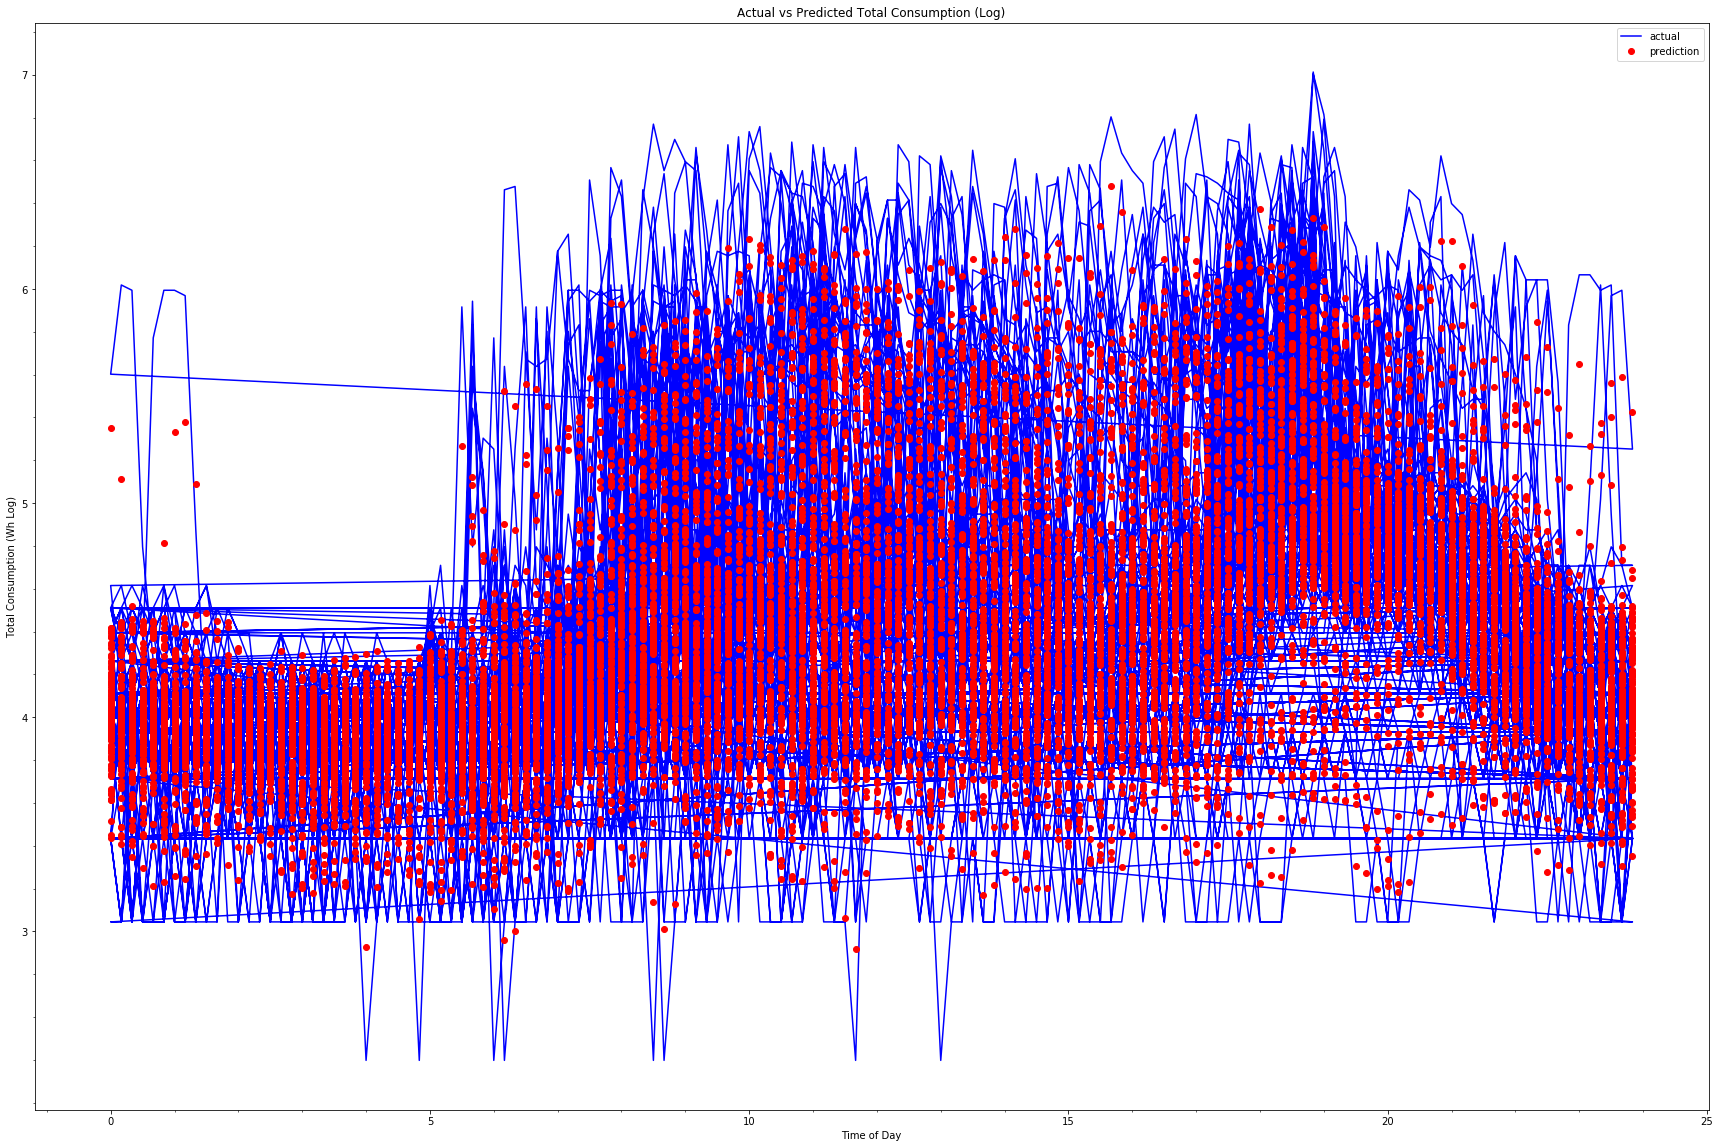

In [58]:
plt.figure(figsize = (30,20))

# Plot the actual values
plt.plot(df['time'], y, 'b-', label = 'actual')
# Plot the predicted values
plt.plot(df['time'], rfr.predict(df), 'ro', label = 'prediction')
plt.legend()
plt.minorticks_on()
# Graph labels
plt.xlabel('Time of Day'); plt.ylabel('Total Consumption (Wh Log)'); plt.title('Actual vs Predicted Total Consumption (Log)');

### Summary

Based on the data set description, the target variable is the total consumption in watt-hours based on the day, time, month, temperature, and humidity in 9 different rooms as well as the outside. The outside pressure, visibility and wind speed are also given as features to determine target energy use. Therefore, we are using regression to solve for a continuous target variable, figure out which features contribute the most to total consumption in watt-hours, and perhaps how to lower total consumption based on the different variables. I elected to use decision tree and random forest regressors because they tend to work well with a relatively sparse dataset than that for linear or polynomial regression. As I will illustrate below, the stepwise branches, leafs, and nodes will have better accuracy.

Because we are using decision trees and random forest, those algorithms are more leninent for outliers because the threshold system would rule that to be one grouping instead of having extreme outliers influence the overall model for regular linear or polynomial modeling. In some cases, outliers are preferred because nuances with the dataset could be detected with decision trees and random forest that continuous equation models would not pick up on for the fitting process.

For feature engineering, the heat index combines humidity and temperature into one overall temperature. Using the Australian Apparent temperature equation, it factors everything in the metric system involving temperature, humidity, and wind speed to create one overall heat and wind chill index. Allowing for the assumption that humans are in the rooms, the "feeling" of temperature can be greatly influenced by how humid a room is. Therefore, a equation is used to determine if overall temperature could influence heating, which would contribute to overall energy consumption. 

Instead of getting a 'lucky sample' by splitting an arbitrary amount by index, the kfold method was used to shuffle the indexed training and testing data values and have the model learn from every fold so it is not overfitted on one given 80:20 split. From the folding process, the training and testing datasets are split 3 times and shuffled to avoid overfitting of a single split dataset with the regular 80:20 split.

For Feature Importance, time of day, certain room temperature, heat index, and days since the beginning of 2016 proved to be the top important features to determine total energy consumption. Due to the complexity of the heat index and apparent temperature from feature engineering, those are included with their original temperature, humidity, and wind chill constituents because some rooms may be more used by people and others are more for appliances, however warm or however cold depending on the outside temperature. Even though pressure does not have an equation for feature engineering, it was surprising that it contributed towards the top 5 important features.

After dropping the less important features with 0.01 feature importance or lower, the mean absolute and accuracy values increased possibly because those features were overfitted and the algorithm became better once those were removed.

Time of day is the most important factor for determining total energy consumption and the best way to visualize the prediction values after is to have time of day on the x axis while comparing total consumption on the y.

With the hyperparameters tuned based on max features of square root, a min samples split of 4, and a criterion of mean absolute error, the number of estimators are increased for the model to be more accurate while using the kfold process. The model is 94.8% accurate with an mean absolute error of 0.23 log wH.

Due to the scattered nature of the dataset, time of day is the best feature to plot against total consumption for a pattern to emerge. All of the rest of the features are less as important. As shown, night time energy consumption is low between 11 pm until 7 am. Then there is a hump in energy consumption from 7 am to 3 pm. The dip at 3 pm is followed by another hump from 4 pm to 11 pm. 